In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import utils as utils

sns.set_color_codes("muted")


# 1. Load the data

- https://www.kaggle.com/atulanandjha/imdb-50k-movie-reviews-test-your-bert

- https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained#7.-LSTM


In [3]:
!kaggle datasets download -d atulanandjha/imdb-50k-movie-reviews-test-your-bert -p data

!unzip data/imdb-50k-movie-reviews-test-your-bert -d data


100%|██████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 26.0MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 27.2MB/s]
Archive:  data/imdb-50k-movie-reviews-test-your-bert.zip
  inflating: data/test.csv           
  inflating: data/train.csv          


# 2. Data Profile

In [4]:
df = pd.read_csv('./data/train.csv')


In [5]:
df.shape


(25000, 2)

In [6]:
df.head()


,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [7]:
df = utils.check_duplicated(df)


96 duplicated rows!
Remove duplicates...
No duplicated rows!


In [8]:
utils.missing_table(df)


No missing values!


## Class Distribution

pos    12472
neg    12432
Name: sentiment, dtype: int64

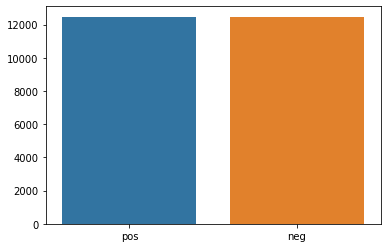

In [9]:
label_counts = df['sentiment'].value_counts()

sns.barplot(x=label_counts.index, y=label_counts.values)

label_counts


## Word Cloud

In [10]:
from wordcloud import WordCloud

def plot_word_cloud(text, size=(8, 8)):
    wordcloud = WordCloud(
        background_color = 'white',
        random_state = 42
    ).generate(text)

    plt.figure( figsize=size )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
def plot_confuse_matrix(conf_matrix, size=(6, 4)):
    fig, ax = plt.subplots(figsize=size)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    
    sns.heatmap(
        [[tp, fp], [fn, tn]], 
        annot=True, annot_kws={"size": 14}, fmt='g',
        xticklabels=['Positive', 'Negative'],
        yticklabels=['Positive', 'Negative']
    )

    # ax.set_title('Confusion matrix',  )
    ax.set_xlabel('Real value', fontsize=14)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Predicted value', fontsize=14)

    plt.show()

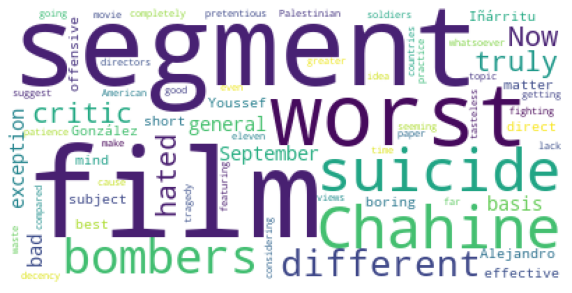

In [11]:
plot_word_cloud(df.iat[22, 0], size=(10, 10))


# 3. Text Preprocessing

## Cleaning

- lower the text string
 
 
- tokenization, split text into a smaller unit
  - sentence-level
  - word-level
 

- remove useless elements
    - punctuation
     - 'string' module

    - stop words such as 'a', 'of'
        - built-in set of stop words in NLTK

    - Special symbols, '<, @, \$'
        - customized rules
    
    - empty unit
        - len(token)
    
    - maybe hyperlink
    


- POS, https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    - J, Adjective
    - R, Adverb
    - N, Noun
    - V, Verb

- stemming(too simple) and lemmatization(with context and morphological analysis)
    - normalize a word into its 'root' form
  
 

In [12]:
import string, re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuxiaopan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wuxiaopan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:

def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ

    elif tag.startswith("R"):
        return wordnet.ADV
    
    elif tag.startswith("V"): 
        return wordnet.VERB
    
    else:
        return wordnet.NOUN


digit = re.compile(r'[0-9]+')
text_br = re.compile(r'<br\s*/><br\s*/>>*|(\-)|(\\)|(\/)')
text_line_end = re.compile(r'\n')

stop_words_en = stopwords.words('english')
lem = WordNetLemmatizer()

def clean_sentence(text):
    # lower
    text = text.lower()

    text = digit.sub('', text)
    text = text_br.sub('', text)
    text = text_line_end.sub(r' ',text)
    text = text.translate(str.maketrans('','',string.punctuation))

    # tokenization, [a, went, c, ...]
    tokens = word_tokenize(text) # text.split(' ') # naive methods, e.g. New York will be splitted into ['New', 'York']
    

    # pos tagging, [(a, 'NN'), (went, 'VB'), (c, 'NN')]
    tokens = pos_tag(tokens)

    # lemmatize, [a, go, c, ...]
    tokens = [ lem.lemmatize(w, get_wordnet_pos(tag)) for w, tag in tokens ]
    
    # remove noise from data
    tokens = [ w for w in tokens if w not in stop_words_en ]
    tokens = [ w for w in tokens if len(w) > 1 ]

    return ' '.join(tokens)


In [14]:
df['cleaned_text'] = df['text'].map(lambda t: clean_sentence(t))

df.head()


,text,sentiment,cleaned_text
0,"Now, I won't deny that when I purchased this o...",neg,wont deny purchase ebay high expectation incre...
1,"The saddest thing about this ""tribute"" is that...",neg,sad thing tribute almost singer include otherw...
2,Last night I decided to watch the prequel or s...,neg,last night decide watch prequel shall say call...
3,I have to admit that i liked the first half of...,neg,admit like first half sleeper look good acting...
4,I was not impressed about this film especially...,neg,impressed film especially fact go cinema famil...


## Target encoding

In [15]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

df['label'] = labelEncoder.fit_transform(df['sentiment'])

df.head()


,text,sentiment,cleaned_text,label
0,"Now, I won't deny that when I purchased this o...",neg,wont deny purchase ebay high expectation incre...,0
1,"The saddest thing about this ""tribute"" is that...",neg,sad thing tribute almost singer include otherw...,0
2,Last night I decided to watch the prequel or s...,neg,last night decide watch prequel shall say call...,0
3,I have to admit that i liked the first half of...,neg,admit like first half sleeper look good acting...,0
4,I was not impressed about this film especially...,neg,impressed film especially fact go cinema famil...,0


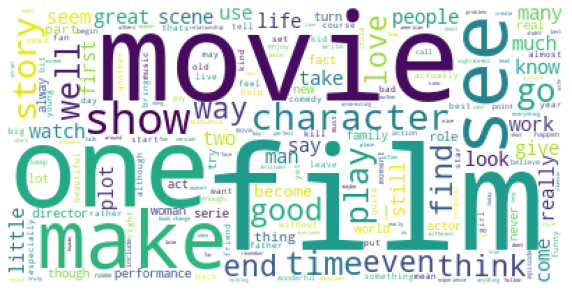

In [16]:
plot_word_cloud(''.join(df.loc[df['label']==1, 'cleaned_text']), size=(10, 10))


# 4. Split train test

In [35]:
def load_data(fname='./data/train.csv'):
    df = pd.read_csv(fname)
    df = utils.check_duplicated(df)
    
    df['cleaned_text'] = df['text'].map(lambda t: clean_sentence(t))
    df['cleaned_word_len'] = [ len(x.split()) for x in df['cleaned_text'] ]
    df = df[df['cleaned_word_len'] > 1]

    labelEncoder = LabelEncoder()
    df['label'] = labelEncoder.fit_transform(df['sentiment'])
    
    X = df['cleaned_text']
    y = df['label']

    print('X.shape, ', X.shape, 'y.shape: ', y.shapre)
    
    return X, y


In [17]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_raw.shape, X_test_raw.shape, y_train.shape, y_test.shape


((19923,), (4981,), (19923,), (4981,))

In [18]:
def build_word_id_mapping(corpus):
    vocabulary = set(corpus)
    voc_size = len(vocabulary)
    
    word_dict = {}
    inverse_word_dict = {}

    for i, word in enumerate(vocabulary):
        word_dict[word] = i
        inverse_word_dict[i] = word

    return voc_size, word_dict, inverse_word_dict


In [19]:
movie_vocabulary = set(' '.join(X_train_raw.values).split())

movie_vocab_size, movie_word_dict, movie_inverse_word_dict = build_word_id_mapping(' '.join(X_train_raw.values).split())

movie_vocab_size, len(movie_word_dict)


(110592, 110592)

In [36]:
test_X, test_y = load_data(fname='./data/test.csv')


199 duplicated rows!
Remove duplicates...
No duplicated rows!


AttributeError: 'Series' object has no attribute 'shapre'

# 5. Text Feature extraction

Frequency-based

- BOW
    - doc-term matrix (frequency)


- TF-IDF
    - $tf(w_j, d_i) * idf(w_j) = \frac{|w_j|}{|d_i|} \text{log} \frac{|D|}{|D_{w_j}|}$, where
        - $tf(w_j, d_i)$ is the frequency of the word $w_j$ in a doc $d_i$
        - $|D|$ is the total number of documents
        - $|D_{w_j}|$ is the number of documents that contain the word $_j$


Context-based(Train our own embeddings)

- CBOW
    - predict the target word given the context words

- Skip gram


Pre-trained embeddings

- Word2Vec

- Glove


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve, auc
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import torch


## One-Hot

In [21]:
# toy example

corpus = [
    'Dog bites man.',
    'Man bites dog.',
    'Dog bites dog.',
    'Man likes meat.',
    'Dog likes bone.'
]

tokens = [clean_sentence(sen) for sen in corpus]

vocabulary = sorted(set(' '.join(tokens).split()))

tokens, vocabulary,


(['dog bite man',
  'man bite dog',
  'dog bite dog',
  'man like meat',
  'dog like bone'],
 ['bite', 'bone', 'dog', 'like', 'man', 'meat'])

In [22]:
# one-hot

word2id = {v: i for i, v in enumerate(vocabulary)}

id2word = {i: v for v, i in word2id.items()}

print(word2id)

def get_onehot_sentence(text):
    text_tensor = torch.zeros(len(text.split()), len(vocabulary))

    mask_tensor = torch.tensor([ word2id[t] for t in text.split() ]).view(-1, 1)

    text_tensor.scatter_(1, mask_tensor, 1)

    return text_tensor.numpy()

tokens[1], get_onehot_sentence(tokens[1])


{'bite': 0, 'bone': 1, 'dog': 2, 'like': 3, 'man': 4, 'meat': 5}


('man bite dog',
 array([[0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]], dtype=float32))

In [23]:
# bag of word - frequency

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

bow_rep = vectorizer.fit_transform(tokens)

print(
    vectorizer.vocabulary_, 
    bow_rep.toarray(),
    vectorizer.transform(["dog and dog are friends"]).toarray()
)


{'dog': 2, 'bite': 0, 'man': 4, 'like': 3, 'meat': 5, 'bone': 1} [[1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 2 0 0 0]
 [0 0 0 1 1 1]
 [0 1 1 1 0 0]] [[0 0 2 0 0 0]]


In [24]:
# bag of word - occurrence
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bin = CountVectorizer(binary=True)
bow_rep_bin = vectorizer_bin.fit_transform(tokens)

print(
    vectorizer_bin.vocabulary_, 
    bow_rep_bin.toarray(),
    vectorizer_bin.transform(["dog and dog are friends"]).toarray()
)


{'dog': 2, 'bite': 0, 'man': 4, 'like': 3, 'meat': 5, 'bone': 1} [[1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 0 0]
 [0 0 0 1 1 1]
 [0 1 1 1 0 0]] [[0 0 1 0 0 0]]


## BOW

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# frequency
vectorizer = CountVectorizer()

X_train_dtm = vectorizer.fit_transform(X_train_raw)
X_test_dtm = vectorizer.transform(X_test_raw)

print(len(vectorizer.get_feature_names()))


110311


In [26]:
# occurrence
vectorizer_bin = CountVectorizer(binary=True)

X_train_dtm_bin = vectorizer_bin.fit_transform(X_train_raw)
X_test_dtm_bin = vectorizer_bin.transform(X_test_raw)

print(len(vectorizer_bin.get_feature_names()))


110311


### Naive Bayes Model

Train acc: 0.9248, Test acc: 0.8480


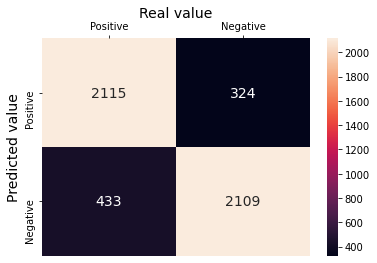

In [27]:
# frequency

mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)

y_train_pred = mnb.predict(X_train_dtm)
y_test_pred = mnb.predict(X_test_dtm)

print('Train acc: %.4f, Test acc: %.4f' 
      % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
)

plot_confuse_matrix(confusion_matrix(y_test, y_test_pred))


Train acc: 0.9356, Test acc: 0.8516


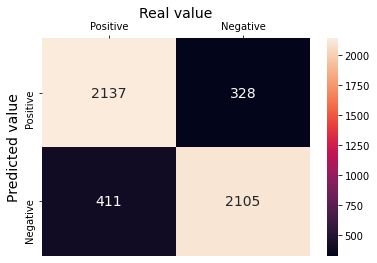

In [28]:
# occurrence

mnb = MultinomialNB()
mnb.fit(X_train_dtm_bin, y_train)

y_train_bin_pred = mnb.predict(X_train_dtm_bin)
y_test_bin_pred = mnb.predict(X_test_dtm_bin)

print('Train acc: %.4f, Test acc: %.4f' 
      % (accuracy_score(y_train, y_train_bin_pred), 
         accuracy_score(y_test, y_test_bin_pred))
)

plot_confuse_matrix(confusion_matrix(y_test, y_test_bin_pred))


### Single Layer Network

In [29]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class BOWClassifier(nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc = nn.Linear(v_size, c_size)

    def forward(self, inputs):
        y = self.fc(inputs)
        p = torch.sigmoid(y)
        return p


In [30]:
def train_single_layer_nn(
    X_train, y_train, X_test, y_test, 
    epoches, model, loss_fn, optimizer
):
    for epoch in range(epoches):
        y_train_pred = model(X_train)
        loss_train = loss_fn(y_train_pred, y_train)
    
        with torch.no_grad():
            y_test_pred = model(X_test)
            loss_test = loss_fn(y_test_pred, y_test)

        model.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch % 2 == 0:
            print(
                'Epoch %d/%d , Train Loss: %.4f, Test Loss: %.4f' 
                % (epoch + 1, epoches, loss_train.item(), loss_test.item())
            )
    

In [31]:
def train_BOW(X_train, y_train, X_test, y_test):

    model = BOWClassifier(X_train.shape[1], 1)
    
    loss_fn = nn.BCELoss()
    
    optimizer = optim.Adam(model.parameters(), lr = 0.01)

    print('Model: ', model)

    train_single_layer_nn(
        X_train, y_train, 
        X_test, y_test,
        20, model, loss_fn, optimizer
    )

    positive_prob = model(X_test).detach()
    negative_prob = torch.ones((len(y_test), 1)) - positive_prob

    y_test_prob = torch.cat([negative_prob, positive_prob], dim=1)
    _, y_test_pred = torch.max(y_test_prob, dim=1)

    print('Test acc: %.4f' % accuracy_score(y_test, y_test_pred))




In [32]:
train_BOW(
    torch.from_numpy(X_train_dtm.todense()).float(),

    torch.tensor(y_train.values).view(-1, 1).float(),
    
    torch.from_numpy(X_test_dtm.todense()).float(),
    
    torch.tensor(y_test.values).view(-1, 1).float()
)


Model:  BOWClassifier(
  (fc): Linear(in_features=110311, out_features=1, bias=True)
)
Epoch 1/20 , Train Loss: 0.6924, Test Loss: 0.6924
Epoch 3/20 , Train Loss: 0.5012, Test Loss: 0.5600
Epoch 5/20 , Train Loss: 0.3949, Test Loss: 0.4888
Epoch 7/20 , Train Loss: 0.3242, Test Loss: 0.4423
Epoch 9/20 , Train Loss: 0.2732, Test Loss: 0.4098
Epoch 11/20 , Train Loss: 0.2348, Test Loss: 0.3870
Epoch 13/20 , Train Loss: 0.2052, Test Loss: 0.3702
Epoch 15/20 , Train Loss: 0.1816, Test Loss: 0.3576
Epoch 17/20 , Train Loss: 0.1626, Test Loss: 0.3489
Epoch 19/20 , Train Loss: 0.1468, Test Loss: 0.3427
Test acc: 0.8753


In [33]:
train_BOW(
    torch.from_numpy(X_train_dtm_bin.todense()).float(),

    torch.tensor(y_train.values).view(-1, 1).float(),
    
    torch.from_numpy(X_test_dtm_bin.todense()).float(),
    
    torch.tensor(y_test.values).view(-1, 1).float()
)

Model:  BOWClassifier(
  (fc): Linear(in_features=110311, out_features=1, bias=True)
)
Epoch 1/20 , Train Loss: 0.6930, Test Loss: 0.6930
Epoch 3/20 , Train Loss: 0.5269, Test Loss: 0.5828
Epoch 5/20 , Train Loss: 0.4222, Test Loss: 0.5133
Epoch 7/20 , Train Loss: 0.3504, Test Loss: 0.4668
Epoch 9/20 , Train Loss: 0.2977, Test Loss: 0.4330
Epoch 11/20 , Train Loss: 0.2573, Test Loss: 0.4080
Epoch 13/20 , Train Loss: 0.2256, Test Loss: 0.3893
Epoch 15/20 , Train Loss: 0.2002, Test Loss: 0.3746
Epoch 17/20 , Train Loss: 0.1795, Test Loss: 0.3634
Epoch 19/20 , Train Loss: 0.1623, Test Loss: 0.3550
Test acc: 0.8675


## TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()

X_train_idf = tfidf.fit_transform(X_train_dtm)

X_test_idf = tfidf.transform(X_test_dtm)


### Naive Bayes Model

Train acc: 0.9223, Test acc: 0.8599


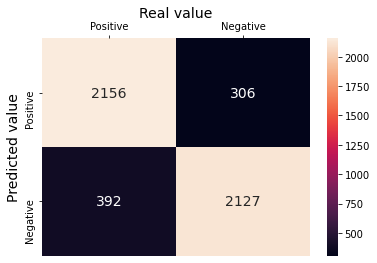

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train_idf, y_train)

y_train_pred = mnb.predict(X_train_idf)
y_test_pred = mnb.predict(X_test_idf)

print('Train acc: %.4f, Test acc: %.4f' 
      % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
)
plot_confuse_matrix(confusion_matrix(y_test, y_test_pred))


## CBOW

In [105]:

def build_word_id_mapping(corpus):
    vocabulary = set(corpus)
    voc_size = len(vocabulary)
    
    word_dict = {}
    inverse_word_dict = {}

    for i, word in enumerate(vocabulary):
        word_dict[word] = i
        inverse_word_dict[i] = word

    return voc_size, word_dict, inverse_word_dict


def get_context_idx(context, word_dict):
    '''
    context: ['a', 'b', 'c']
    '''
    idx = [ word_dict[w] for w in context ]

    return torch.tensor(idx, dtype=torch.long)

def build_context_target(text, win_size = 2):
    data = []

    for i in range(win_size, len(text) - win_size):
        context = [
            text[i-2], text[i-1],
            text[i+1], text[i+2],
        ]
        
        target=text[i]
    
        data.append((context, target))

    return data

class CBow(nn.Module):
    def __init__(self, v_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(v_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, v_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, inputs):
        embedding = sum(self.embedding(inputs)).view(1, -1) # (1, E)
        out = self.fc1(embedding)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

def training(model, data, v_size, word_dict):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.NLLLoss()

    epoches = 10
    for epoch in range(epoches):
        epoch_loss = 0
        for context, target in data:
            context_ids = get_context_idx(context, word_dict)

            log_probs = model(context_ids)
            loss = loss_fn(log_probs, torch.tensor([word_dict[target]], dtype=torch.long))

            model.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # if epoch == 0 or (epoch + 1) % 10 == 0:
        print('Epoch %d/%d, Train Loss: %4.f' % (epoch + 1, epoches, epoch_loss))

def find_similarity(
    embedding,
    word_dict, inverse_word_dict, v_size, 
    word, top_n
):
    v_w1 = embedding( torch.tensor( [ word_dict[word] ], dtype=torch.long ) ).detach().numpy()

    word_sim = {}
    for i in range(v_size):
        v_w2 = embedding(torch.tensor(i)).detach().numpy()
        theta = np.dot(v_w1, v_w2) / (np.linalg.norm(v_w1) * np.linalg.norm(v_w2))
        word = inverse_word_dict[i]
        word_sim[word] = theta

    words_sorted = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)

    for word, sim in words_sorted[:top_n]:
        print(word, sim)


In [110]:
partial_text = X_train_raw[:100].values

# step1
data = []
for sentence in partial_text:
    d = build_context_target(sentence.split())
    data = data + d

# step2
v_size, word_dict, inverse_word_dict = build_word_id_mapping(' ' .join(partial_text).split())

model = CBow(v_size, 20, 32)

training(model, data, v_size, word_dict)


Epoch 1/10, Train Loss: 88789
Epoch 2/10, Train Loss: 83852
Epoch 3/10, Train Loss: 81109
Epoch 4/10, Train Loss: 78411
Epoch 5/10, Train Loss: 75408
Epoch 6/10, Train Loss: 72101
Epoch 7/10, Train Loss: 68703
Epoch 8/10, Train Loss: 65380
Epoch 9/10, Train Loss: 62267
Epoch 10/10, Train Loss: 59426


In [127]:
find_similarity(
    model.embedding, word_dict, inverse_word_dict, v_size,
    'favorite', 6
)


favorite [1.]
oppressive [0.68966645]
elegance [0.6868655]
original [0.66566545]
compleat [0.6439938]
possible [0.6302605]


## Word2Vec

In [ ]:
# https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/03_Word2Vec_Example.ipynb


In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_idf, y_train)

y_train_pred = mnb.predict(X_train_idf)
y_test_pred = mnb.predict(X_test_idf)

print('Train acc: %.4f, Test acc: %.4f' 
      % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
)
plot_confuse_matrix(confusion_matrix(y_test, y_test_pred))


## Glove

In [129]:
!wget http://nlp.stanford.edu/data/glove.6B.zip  
!unzip glove.6B.zip 


--2021-06-24 09:43:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-24 09:43:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-24 09:43:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [28]:
def read_glove():
    word_dict = {}
    with open('./data/glove.6b.50d.txt', 'r') as f:
        for line in f:
            tokens = line.split()
            word = tokens[0]
            vector = np.array(tokens[1:], dtype=np.float)
            if vector.shape[0] == 50:
                word_dict[word] = vector
            else:
                print('no vector representation')
    return word_dict


In [29]:
glove_word_dict = read_glove()

print('Vocabulary size: ', len(glove_word_dict))

glove_word_dict['dog']


Vocabulary size:  400000


array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ])

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(
    glove_word_dict['dog'].reshape(1, -1),
    glove_word_dict['cat'].reshape(1, -1)
)

array([[0.92180053]])

### Embedding matrix

In [31]:

def build_movie_embedding_from_glove(
    glove_word_dict,
    movie_vocabulary, 
    movie_word_dict
):
    embed_dim = glove_word_dict['dog'].shape[0]
    embed_matrix = np.zeros((len(movie_vocabulary), embed_dim))

    count = 0
    for i, word in enumerate(movie_vocabulary):
        word_id = movie_word_dict[word]

        try:            
            embed_matrix[word_id] = glove_word_dict[word]
            count += 1

        except KeyError:
            embed_matrix[word_id] = np.random.normal(scale=0.6, size=(embed_dim,))

    print('%.4f (%d) words found' % (count / len(movie_vocabulary), count))
    return embed_matrix


In [32]:
movide_embed_matrix = build_movie_embedding_from_glove(
    glove_word_dict,
    movie_vocabulary, 
    movie_word_dict
)


0.4268 (47201) words found


In [33]:
movide_embed_matrix[movie_word_dict['dog']]


array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ])

In [34]:
cosine_similarity(
    movide_embed_matrix[movie_word_dict['dog']].reshape(1, -1),
    movide_embed_matrix[movie_word_dict['cat']].reshape(1, -1)
)


array([[0.92180053]])

# 6. Traditional ML Models



- LinearSVC

- Multinomial Naive Bayes

- Logistic

- Voting



In [38]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


In [160]:
classifiers = {
    'LinearSVC': LinearSVC(),
    'MultinomialNB': MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
}

def model_selection(X_train, y_train, X_test, y_test):
    score_mean, score_std, test_acc, auc = [], [], [], []

    for cls_name, cls_model in classifiers.items():
        pipe = Pipeline([
            ('count', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('classifier', cls_model)
        ])

        scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='accuracy')
        score_mean.append(scores.mean())
        score_std.append(scores.std())

        pipe.fit(X_train, y_train)
        y_test_pred = pipe.predict(X_test)

        test_acc.append(accuracy_score(y_test, y_test_pred))

        print(cls_name, ' done')

    result = pd.DataFrame(
        list(zip(score_mean, score_std, test_acc)), 
        columns=["train_acc_mean", "train_acc_std", 'test_acc']
    )
    result["model"] = classifiers.keys()
    print(result)




In [161]:

model_selection(X_train_raw, y_train, X_test_raw, y_test)


LinearSVC  done
MultinomialNB  done
LogisticRegression  done
   train_acc_mean  train_acc_std  test_acc               model
0        0.880389       0.004488  0.882554           LinearSVC
1        0.856598       0.005968  0.859867       MultinomialNB
2        0.874166       0.003487  0.883156  LogisticRegression


## Voting

In [162]:
classifiers = {
    'LinearSVC': LinearSVC(),
    'MultinomialNB': MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
}
voting_cls = VotingClassifier(
    estimators=[ (name, 
                  Pipeline([
                    ('count', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('classifier', model)
                    ])
                 ) 
                for name, model in classifiers.items()], 
    voting='hard'
)
voting_cls = voting_cls.fit(X_train_raw, y_train)
y_train_pred = voting_cls.predict(X_train_raw)

y_test_pred = voting_cls.predict(X_test_raw)
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)


(0.9607990764443106, 0.8869704878538446)

# 7. RNN

https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/05_DeepNN_Example.ipynb

